# 深層学習を使用した熱中症搬送者数予測

## 1.module, funcion等の準備

### seed値設定

In [5]:
seeds = [100, 200, 300, 400, 500]

### moduleのインポート

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Input, LSTM, Dense, Concatenate, RNN, GRU, SimpleRNN
from keras.wrappers.scikit_learn import KerasRegressor
import keras_tuner as kt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import random
import os
import itertools
import warnings
from pickle import dump, load
from tqdm import tqdm
import json

### 関数の定義

In [9]:
#seed値固定用関数：結果に再現性をもたせるため
def set_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)


#LSTM用の時系列データの前処理用関数(学習データ用)：
### 引数：meteorological_input(入力ファイル), target_cols(入力変数), target_years(対象年度),target_month_list(対象月設定), timesteps(使用する連続日数)
def LSTM_input_train(meteorological_input, target_cols, target_years, target_month_list, timesteps):
    input_dict = {}
    standardization_dict = {}
    for target_col in target_cols:
        target_input = meteorological_input[['Date', 'Year', 'Month', 'Day', target_col]]
        target_input_for_standardization = target_input[(target_input['Year'].isin(target_years))&(target_input['Month'].isin(target_month_list))]
        scaler = StandardScaler()
        scaler.fit(target_input_for_standardization[[target_col]])
        standardization_dict[target_col] = scaler
        target_input[target_col] = scaler.transform(target_input[target_col].to_numpy().reshape(-1, 1))
        for i in range(timesteps):
            target_input[f'lag_{i}'] = target_input[target_col].shift(i)
        target_input = target_input[target_input['Year'].isin(target_years)]
        input_dict[target_col] = target_input[target_input['Month'].isin(target_month_list)].reset_index(drop=True)


    # [batch, timesteps, feature]の形にする
    reshaped_dict = {}
    for target_col in target_cols:
        _x = input_dict[target_col].loc[:, 'lag_0':f'lag_{timesteps-1}']
        reshaped_dict[target_col] = np.array(_x).reshape(-1, timesteps)

    input_format = []
    _format1 = []
    _tentative = []
    for i in range(0, len(reshaped_dict[target_cols[0]])):
        for j in range(0, timesteps):
            for k in range(0, len(target_cols)):
                _tentative.append(reshaped_dict[target_cols[k]][i][j])
            _format1 .append(_tentative)
            _tentative = []
        input_format.append(_format1)
        _format1 = []
    input_format = np.array(input_format)

    return input_format, standardization_dict

#LSTM用の時系列データの前処理用関数(テストデータ用)：
### 引数：meteorological_input(入力ファイル), target_cols(入力変数), target_years(対象年度),target_month_list(対象月設定), timesteps(使用する連続日数), standardization_dict:学習データから算出した標準化の為の標準偏差・平均値読み込み
def LSTM_input_test(meteorological_input, target_cols, target_years, target_month_list, timesteps, standardization_dict):
    input_dict = {}
    for target_col in target_cols:
        target_input = meteorological_input[['Date', 'Year', 'Month', 'Day', target_col]]
        target_input[target_col] = standardization_dict[target_col].transform(target_input[target_col].to_numpy().reshape(-1, 1))
        for i in range(timesteps):
            target_input[f'lag_{i}'] = target_input[target_col].shift(i)
        target_input
        #target_month_list = [7,8]
        target_input = target_input[target_input['Year'].isin(target_years)]
        input_dict[target_col] = target_input[target_input['Month'].isin(target_month_list)].reset_index(drop=True)


    # [batch, timesteps, feature]の形にする
    reshaped_dict = {}
    for target_col in target_cols:
        _x = input_dict[target_col].loc[:, 'lag_0':f'lag_{timesteps-1}']
        reshaped_dict[target_col] = np.array(_x).reshape(-1, timesteps)

    input_format = []
    _format1 = []
    _tentative = []
    for i in range(0, len(reshaped_dict[target_cols[0]])):
        for j in range(0, timesteps):
            for k in range(0, len(target_cols)):
                _tentative.append(reshaped_dict[target_cols[k]][i][j])
            _format1 .append(_tentative)
            _tentative = []
        input_format.append(_format1)
        _format1 = []
    input_format = np.array(input_format)

    return input_format


#NN用の非時系列データの前処理用関数(学習データ用)：
### 引数：meteorological_input(入力ファイル), target_cols(入力変数), target_years(対象年度),target_month(対象月設定)
def single_input_train(meteorological_input, target_cols, target_years, target_month):
    standardization_dict = {}
    feat_data_dict = {}
    for target_col in target_cols:
        # print(target_col)
        feat_data = meteorological_input[meteorological_input['Year'].isin(target_years)].reset_index()
        feat_data = feat_data[feat_data['Month'].isin(target_month)].reset_index(drop=True)[target_col].to_numpy().reshape(-1, 1)
        scaler = StandardScaler()
        scaler.fit(feat_data)
        standardization_dict[target_col] = scaler
        feat_data = scaler.transform(feat_data)
        feat_data = [[e] for e in feat_data]
        feat_data = np.array(feat_data)
        feat_data_dict[target_col] = feat_data
    return feat_data_dict, standardization_dict

#NN用の非時系列データの前処理用関数(テストデータ用)：
### 引数：meteorological_input(入力ファイル), target_cols(入力変数), target_years(対象年度),target_month(対象月設定),standardization_dict:学習データから算出した標準化の為の標準偏差・平均値読み込み
def single_input_test(meteorological_input, target_cols, target_years, target_month, standardization_dict):
    feat_data_dict = {}
    for target_col in target_cols:
        feat_data = meteorological_input[meteorological_input['Year'].isin(target_years)].reset_index()
        feat_data = feat_data[feat_data['Month'].isin(target_month)].reset_index(drop=True)[target_col].to_numpy().reshape(-1, 1)
        feat_data = standardization_dict[target_col].transform(feat_data)
        feat_data = [[e] for e in feat_data]
        feat_data = np.array(feat_data)
        feat_data_dict[target_col] = feat_data
    return feat_data_dict

##ダミー変数の当日データのinput前処理用関数
def dummy_input(meteorological_input, target_cols, target_years, target_month):
    dummy_data_dict = {}
    for target_col in target_cols:
        dummy_data = meteorological_input[meteorological_input['Year'].isin(target_years)].reset_index()
        dummy_data = dummy_data[dummy_data['Month'].isin(target_month)].reset_index(drop=True)[target_col].to_numpy().reshape(-1, 1)
        dummy_data = [[e] for e in dummy_data]
        dummy_data = np.array(dummy_data)
        dummy_data_dict[target_col] = dummy_data
    return dummy_data_dict


#自由度調整済み決定係数
def adj_r2_score(y_true, y_pred, p):
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)


#辞書の保存用関数
def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)


### 屋内屋外、高齢者大人区分の設定用関数
### 予測値を屋内・屋外や高齢者・大人で分けて予測する時用の関数
def make_y_distinct_flag(target_cols_y_distinct, year_list, month_list):
    input_dict = {}
    if month_list == [7,8]:
        month_len = 62
    elif month_list == [6,7,8,9]:
        month_len = 122
    
    if (target_cols_y_distinct == ['INOUT_flag'])|(target_cols_y_distinct == ['AE_flag']):
        num = month_len*len(year_list)*2
        pattern = [0, 1] * (num // 2)
        # パターンをnumpy配列に変換
        input_dict[target_cols_y_distinct[0]] = np.array(pattern[:num]).reshape(num, 1, 1)
    elif (target_cols_y_distinct == ['INOUT_flag', 'AE_flag']):
        num = month_len*len(year_list)*4
        for flag in target_cols_y_distinct:
            if flag == 'INOUT_flag':
                pattern = [0, 0, 1, 1] * (num // 4)
            elif flag == 'AE_flag':
                pattern = [0, 1, 0, 1] * (num // 4)
            else:
                raise ValueError("Invalid target_cols_y_distinct value.")
            input_dict[flag] = np.array(pattern[:num]).reshape(num, 1, 1)
    return input_dict

### ydataのinput作成用関数
def y_input(data, y, target_ydata):
    y_train_list = []
    y_train = data.query(f'Year!={y}').reset_index(drop=True)
    for i in range(len(y_train)):
        for col in target_ydata:
            y_train_list.append(y_train.loc[i, col])
    y_train_list  = [[e] for e in y_train_list]

    y_test_list = []
    y_test = data.query(f'Year=={y}').reset_index(drop=True)
    for i in range(len(y_test)):
        for col in target_ydata:
            y_test_list.append(y_test.loc[i, col])
    y_test_list  = [[e] for e in y_test_list]
    return np.array(y_train_list), np.array(y_test_list)


### 学習の可視化の為の関数
def plot_E(seed, history_dict):
    plt.rcParams['figure.figsize'] = 20, 22.5  # 画像サイズの変更
    plt.rcParams["font.size"] = 18

    markers = {2020: "o", 2021: "^", 2022: "v"}
    x_dict = {}
    for y in  range(2020, 2023, 1):
        x_dict[f'{y}_{seed}'] = np.arange(1, len(history_dict[f'{y}_{seed}']['loss']) + 1)

    plt.subplot(3, 2, 1)
    plt.title('loss for train data')
    plt.grid()
    for y in  range(2020, 2023, 1):
        plt.plot(x_dict[f'{y}_{seed}'], history_dict[f'{y}_{seed}']['loss'],
                marker=markers[y], markevery=1, label=f'{y}_{seed}')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    #plt.ylim(0, 1)
    plt.legend(loc=1)

    plt.subplot(3, 2, 2)
    plt.title('loss for validation data')
    plt.grid()
    for y in  range(2020, 2023, 1):
        plt.plot(x_dict[f'{y}_{seed}'], history_dict[f'{y}_{seed}']['val_loss'],
                marker=markers[y], markevery=1, label=f'{y}_{seed}')
    plt.xlabel("epochs")
    plt.ylabel("val_loss")
    #plt.ylim(0, 1)
    plt.legend(loc=1)

    plt.subplot(3, 2, 3)
    plt.title('accuracy for train data')
    plt.grid()
    for y in  range(2020, 2023, 1):
        plt.plot(x_dict[f'{y}_{seed}'], history_dict[f'{y}_{seed}']['accuracy'],
                marker=markers[y], markevery=1, label=f'{y}_{seed}')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    #plt.ylim(0.9, 1)
    plt.legend(loc=4)

    plt.subplot(3, 2, 4)
    plt.title('accuracy for validation data')
    plt.grid()
    for y in  range(2020, 2023, 1):
        plt.plot(x_dict[f'{y}_{seed}'], history_dict[f'{y}_{seed}']['val_accuracy'],
                marker=markers[y], markevery=1, label=f'{y}_{seed}')
    plt.xlabel("epochs")
    plt.ylabel("val_acc")
    #plt.ylim(0.9, 1)
    plt.legend(loc=4)

    plt.subplot(3, 2, 5)
    plt.title('MAE for train data')
    plt.grid()
    for y in  range(2020, 2023, 1):
        plt.plot(x_dict[f'{y}_{seed}'], history_dict[f'{y}_{seed}']['mae'],
                marker=markers[y], markevery=1, label=f'{y}_{seed}')
    plt.xlabel("epochs")
    plt.ylabel("mae")
    #plt.ylim(0.9, 1)
    plt.legend(loc=1)

    plt.subplot(3, 2, 6)
    plt.title('MAE for validation data')
    plt.grid()
    for y in  range(2020, 2023, 1):
        plt.plot(x_dict[f'{y}_{seed}'], history_dict[f'{y}_{seed}']['val_mae'],
                marker=markers[y], markevery=1, label=f'{y}_{seed}')
    plt.xlabel("epochs")
    plt.ylabel("val_mae")
    #plt.ylim(0.9, 1)
    plt.legend(loc=1)
    plt.savefig(f'{graph_path}/{model_name}_{seed}')
    plt.show()

## 2.学習と予測


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - ETA: 0s - loss: 466.2199 - accuracy: 0.0605 - mae: 13.4954
Epoch 1: val_loss improved from inf to 148.01331, saving model to ./model_infomation/future_ep1_ba1000_ts60_tmon7-8_全体人流_v2/100/training_checkpoint/2020\checkpoint_future_ep1_ba1000_ts60_tmon7-8_全体人流_v2.h5
4/4 [==============================] - 1s 13ms/step


1/1 [==============================] - ETA: 0s - loss: 513.9207 - accuracy: 0.0605 - mae: 14.3508
Epoch 1: val_loss improved from inf to 146.40776, saving model to ./model_infomation/future_ep1_ba1000_ts60_tmon7-8_全体人流_v2/100/training_checkpoint/2021\checkpoint_future_ep1_ba1000_ts60_tmon7-8_全体人流_v2.h5
4/4 [==============================] - 1s 13ms/step


1/1 [==============================] - ETA: 0s - loss: 501.7854 - accuracy: 0.0650 - mae: 14.0978
Epoch 1: val_loss improved from inf to 131.27553, saving model to ./model_infomation/future_ep1_ba1000_ts60_tmon7-8_全体人流_v2/100/training_checkpoint/2022\checkpoint_future_ep1_ba1000_ts60_tmon7-8_全体人流_v2.h5
4/4 [==============================] - 1s 15ms/step


100%|██████████| 3/3 [00:20<00:00,  6.85s/it]


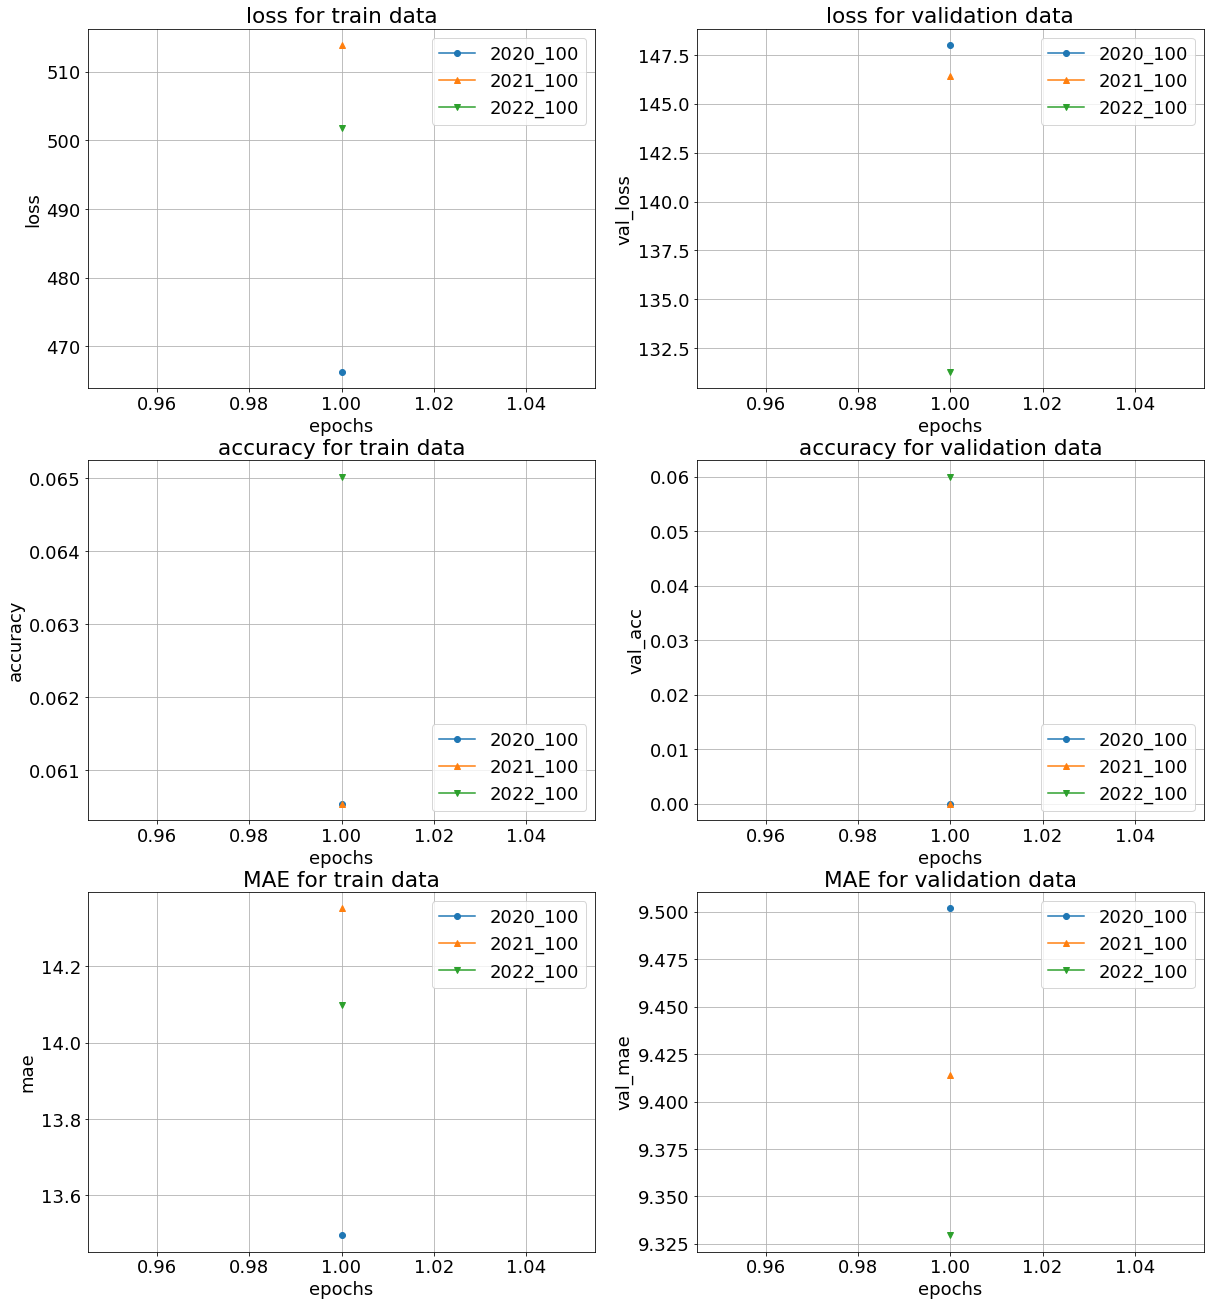

100%|██████████| 1/1 [00:22<00:00, 22.11s/it]


In [10]:
#####初期設定
data=pd.read_csv('../../input/Number_of_patients_in_Nagoya.csv', encoding='cp932')
data=pd.DataFrame(data)
target_month_list = [7,8]
target_test_month_list = [6,7,8,9]
test_years = [x for x in range(2020, 2023, 1)]

train_data = data[data['Month'].isin(target_month_list)]
test_data = data[data['Month'].isin(target_test_month_list)] 

pred_dict = {}
MAE_dict = {}
R2_dict = {}
history_dict = {}

result = pd.DataFrame(columns=[0, 1, 2])

#ignore warnings
warnings.simplefilter('ignore')

#choice for batch_size:1,5, 10, 20
batch_size = 16
#choice for epoch_num:100, 200, 500, 1000
epochs = 1000
timesteps = 60
#seeds = [100]
start_m = target_month_list[0]
end_m = target_month_list[-1] 



######入力変数の準備
meteorological_input = pd.read_csv('../../input/nagoya_meteorological_data_0301-0930.csv')
population_input = pd.read_csv('../../input/stay_population_Nagoya-Station.csv')
x_input = meteorological_input.merge(population_input[['Date', 'stay_population', 'stay_population_raito_2019_6']], how='left', on='Date')
target_cols_sequence = ['average-temperature']
target_cols_single = ['stay_population_raito_2019_6', 'absolute-humidity', 'solar-irradiance']
target_cols_dummy = []
target_ydata = 'NOP_adult_elderly_OUT'

model_name = f'future_ep{epochs}_ba{batch_size}_ts{timesteps}_tmon{start_m}-{end_m}_'
if target_ydata == 'NOP_adult_elderly_IN_OUT':
    model_name += '全体'
elif target_ydata == 'NOP_adult_elderly_IN':
    model_name += '屋内'
elif target_ydata == 'NOP_adult_elderly_OUT':
    model_name += '屋外'

for col in target_cols_single:
    if col == 'absolute-humidity':
        model_name += '湿'
    elif col == 'solar-irradiance':
        model_name += '日'
    elif col == 'wind':
        model_name += '風'
    elif col == 'rainfall':
        model_name += '降水'
    elif col == 'stay_population':
        model_name += '人流'
    elif col == 'stay_population_raito_2019_6':
        model_name += '人流比率'

for col in target_cols_dummy:
    if col == 'rainfall_flag':
        model_name += '雨'
    elif col == 'obon_flag':
        model_name += '盆'

model_name += '_v2'


##### CV法を使った学習と予測
for seed in tqdm(seeds):
    #setting
    pred_list = []
    r2_list = []
    MAE_list = []

    for y in tqdm(range(2020, 2023, 1)):
        #Preprocessing
        #x_data
        train_years_list = [x for x in range(2014, 2023, 1)]
        train_years_list.remove(y)
        test_year_list = [y]
        standardization_dict_sequence = {}
        x_train_sequence, standardization_dict_sequence = LSTM_input_train(x_input, target_cols_sequence, train_years_list, target_month_list, timesteps)

        x_train_single_list = []
        standardization_dict_single = {}
        if len(target_cols_single) != 0:
            x_train_single, standardization_dict_single = single_input_train(x_input, target_cols_single, train_years_list, target_month_list)
            for target_col in target_cols_single:
                x_train_single_list.append(x_train_single[target_col])

        x_train_dummy_list = []
        if len(target_cols_dummy) != 0:
            x_train_dummy = dummy_input(x_input, target_cols_dummy, train_years_list, target_month_list)
            for target_col in target_cols_dummy:
                x_train_dummy_list.append(x_train_dummy[target_col])


        # for reuse standardization_infomation
        #standardization_dict_ = load(open(standardization_filepath+f"/standardization_{model_name}.pkl", "rb"))
        x_test_sequence = LSTM_input_test(x_input, target_cols_sequence, test_year_list, target_test_month_list, timesteps, standardization_dict_sequence)

        x_test_single_list = []
        if len(target_cols_single) != 0:
            x_test_single = single_input_test(x_input, target_cols_single, test_year_list, target_test_month_list, standardization_dict_single)
            for target_col in target_cols_single:
                x_test_single_list.append(x_test_single[target_col])

        x_test_dummy_list = []
        if len(target_cols_dummy) != 0:
            x_test_dummy = dummy_input(x_input, target_cols_dummy, test_year_list, target_test_month_list)
            for target_col in target_cols_dummy:
                x_test_dummy_list.append(x_test_dummy[target_col])

        ## save_standardization_infomation
        standardization_filepath = f'./model_infomation/{model_name}/{seed}/standardization/{y}'
        os.makedirs(standardization_filepath, exist_ok=True)

        dump(standardization_dict_sequence, open(standardization_filepath+f"/standard_sequence_{model_name}.pkl", "wb"))
        if len(target_cols_single) != 0:
            dump(standardization_dict_single, open(standardization_filepath+f"/standard_single_{model_name}.pkl", "wb"))
        
        #y_data
        y_train = train_data.query(f'Year!={y}').reset_index()[target_ydata]
        y_test = test_data.query(f'Year=={y}').reset_index()[target_ydata]
        y_train  = [[e] for e in y_train]
        y_test  = [[e] for e in y_test]
        y_train = np.array(y_train)
        y_test = np.array(y_test)



        ## NN definition
        ## input shape: [batch, timesteps, feature]
        #callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        checkpoint_filepath = f'./model_infomation/{model_name}/{seed}/training_checkpoint/{y}'
        checkpoint_h5_filepath = f'./model_infomation/{model_name}/{seed}/training_checkpoint/{y}/checkpoint_{model_name}.h5'
        os.makedirs(checkpoint_filepath, exist_ok=True)

        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_h5_filepath,
            verbose = 1,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)

        set_seed(seed=seed)
        input_layers = [Input(shape=(timesteps, 1))] + [Input(shape=(1,)) for _ in target_cols_single] + [Input(shape=(1,)) for _ in target_cols_dummy]
        lstm1 = LSTM(60, go_backwards=True, return_sequences=True)(input_layers[0]) #modify
        lstm2 = LSTM(30)(lstm1)
        dense1 = Dense(30)(lstm2)
        concat1 = tf.keras.layers.concatenate(input_layers[1:len(target_cols_single+target_cols_dummy) + 1]) #modify
        dense2 = Dense(30)(concat1)
        concat2 = tf.keras.layers.concatenate([dense1, dense2])
        output = Dense(1)(concat2)

        model = tf.keras.Model(inputs=input_layers, outputs=output)
        opti = tf.keras.optimizers.Adam(
                learning_rate= 0.001,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-05,
                amsgrad=False,
                weight_decay=None,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                jit_compile=True,
                name="Adam")
        model.compile(loss='mean_squared_error', optimizer=opti, metrics=['accuracy', 'mae'])


        ## model train 
        history = model.fit([x_train_sequence]+x_train_single_list+x_train_dummy_list ,y_train ,epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1, callbacks=[model_checkpoint_callback])
        #history = model.fit([x_train_sequence, x_train_single_1, x_train_single_2, x_train_dummy_1, x_train_dummy_2] ,y_train ,epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1, callbacks=[model_checkpoint_callback])
        history_dict[f'{y}_{seed}'] = history.history
        model.load_weights(checkpoint_h5_filepath) 
        model_path = f'./model_infomation/{model_name}/{seed}/model/{y}'
        os.makedirs(model_path, exist_ok=True)
        model.save(model_path+f'/model_{model_name}.h5')

        ## model predict
        y_pred=model.predict([x_test_sequence]+x_test_single_list+x_test_dummy_list)
        pred_list.extend(sum(y_pred.tolist(), []))

    pred_dict[seed] = pred_list

    #post-processing
    #result
    result = pd.DataFrame(pred_dict)
    test_data_for_result = test_data[test_data['Year'].isin(test_years)]
    result['Date'] = test_data_for_result['Date'].to_list()
    result['Observed'] = test_data_for_result[target_ydata].to_list()
    result_columns = ['Date', 'Observed']
    result_columns.append(seed)
    result = result[result_columns]
    result_path = f'./model_infomation/{model_name}/{seed}/result'
    os.makedirs(result_path, exist_ok=True)
    result.to_csv(result_path+f'/result_{model_name}.csv', encoding='cp932')

    #train_history
    history_path = f'./model_infomation/{model_name}/{seed}/history' 
    history_json_path = f'./model_infomation/{model_name}/{seed}/history/history_{model_name}.json'
    os.makedirs(history_path, exist_ok=True)
    with open(history_json_path, "w") as outfile:
        json.dump(history_dict, outfile)

    #visualize_train_history
    graph_path = f'./model_infomation/{model_name}/{seed}/graph'
    os.makedirs(graph_path, exist_ok=True)
    plot_E(seed, history_dict)
